In [1]:
import idx2numpy
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import random as rand
import cv2
np.set_printoptions(suppress=True)

x_digit = idx2numpy.convert_from_file('data/train-images-idx3-ubyte')
y_digit = idx2numpy.convert_from_file('data/train-labels-idx1-ubyte')

print(x_digit.shape, y_digit.shape)
BATCH_SIZE = 256
TRAIN_SIZE = 50000
TEST_SIZE = 10000
EPOCHS = 50
OUTER_IMG_SZ = 512

(60000, 28, 28) (60000,)


In [2]:
### Generate train and test data using mnist set with NUM_SIZE digits
GRID_SIDE = 9

image_dict = [[] for i in range(10)]
for digit,image in zip(y_digit, x_digit):
    image_dict[digit].append(image)

In [70]:
class TestImgGenSequence(keras.utils.Sequence):
    
    def __init__(self, length_of_set, batch_size=BATCH_SIZE):
        self.batch_size = batch_size
        self.length_of_set = length_of_set
        self.epoch_count = 0.0
    
    def __len__(self):
        'Denotes the number of batches per epoch 10k/128'
        ret = self.length_of_set // self.batch_size
        #print("Returning length as " + str(ret))
        return ret

    def __getitem__(self, index):
        'Generate one batch of data'
        #print("Getting item for index " + str(index))
        # Generate indexes of the batch
        #print("using batch_size " + str(self.batch_size))
        x, y = self.gen_test_data(self.batch_size)
        #print("Shapes of returned ", x.shape, y.shape)
        ys = {}
        for op_l in range(GRID_SIDE**2):
            ys[op_l] = y[:,op_l,:]
        return x,ys
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.epoch_count += 1.0
        #print("An epoch ended >>>>>>> xxxxxxx >>>>>> qqq >>>>")
    
    def gen_test_data(self, num_data):
        x_data, y_data = np.zeros((num_data, OUTER_IMG_SZ , OUTER_IMG_SZ)), np.zeros((num_data, GRID_SIDE **2))
        for i in range(num_data):
            #pick a random size so that the grid is at least 50% of the overall image
            border_sz = rand.randint(1,2)
            digit_sz = rand.randint(OUTER_IMG_SZ//(2 * GRID_SIDE), OUTER_IMG_SZ//GRID_SIDE) - 2 * border_sz
            border_digit_sz  = digit_sz + 2 * border_sz
            grid_size = GRID_SIDE * (border_digit_sz)
            #pick random offsets so image doesn't go off screen
            x_offset = rand.randint(0, OUTER_IMG_SZ - grid_size)
            y_offset = rand.randint(0, OUTER_IMG_SZ - grid_size)
            for k in range(GRID_SIDE**2):
                rand_digit = rand.randint(0,9)
                rand_img = rand.choice(image_dict[rand_digit])
                rand_img = cv2.resize(rand_img, (digit_sz, digit_sz))
                if rand_digit == 0 : rand_img = np.zeros((digit_sz, digit_sz))
                rand_img = cv2.copyMakeBorder(rand_img, border_sz,border_sz,border_sz,border_sz, cv2.BORDER_CONSTANT, value = [255,255,255])
                y_data[i,k] = rand_digit
                r = k//GRID_SIDE
                c = k % GRID_SIDE
                x_data[i, y_offset + r*border_digit_sz:y_offset + (r+1)*border_digit_sz, x_offset + border_digit_sz*c:x_offset + border_digit_sz*(c+1)] = rand_img
        x_data /= 255.0
        y_data = tf.one_hot(y_data, 10).numpy()
        return x_data, y_data
    

(512, 512)


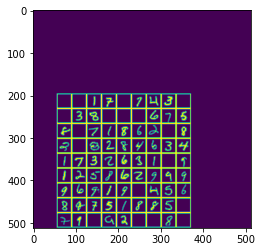

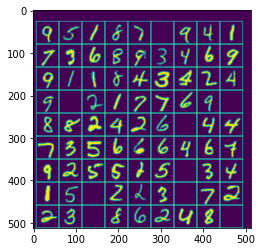

In [200]:
gen = TestImgGenSequence(1)
x,y = gen.gen_test_data(2)
print(x[0].shape)
plt.imshow(x[0])
plt.show()
plt.imshow(x[1])
img1, img2 = x

(512, 512, 1)


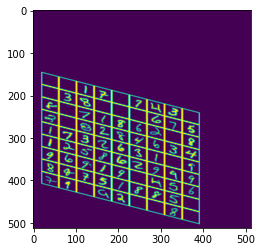

In [211]:
fimg = img1.reshape(512, 512,1)
dgen = tf.keras.preprocessing.image.ImageDataGenerator()
iim = dgen.apply_transform(fimg, {'shear':20, 'zx':1.2, 'zy':0.9})
print(iim.shape)
plt.imshow(iim)

In [25]:
act = 'relu'
pad = 'same'
strd = 1
input_layer = tf.keras.Input(shape = (OUTER_IMG_SZ, OUTER_IMG_SZ,1))
_ = tf.keras.layers.Conv2D(filters=1, kernel_size=3, activation = act, padding = pad, strides=2)(input_layer)
_ = tf.keras.layers.Conv2D(filters=1*2, kernel_size=3, activation = act, padding = pad, strides=strd)(_) 
_ = tf.keras.layers.MaxPool2D()(_)
_ = tf.keras.layers.Conv2D(filters=1*3, kernel_size=3, activation = act, padding = pad, strides = strd)(_) 
_ = tf.keras.layers.Conv2D(filters=1*4, kernel_size=3, activation = act, padding = pad, strides = strd)(_) 
_ = tf.keras.layers.MaxPool2D()(_)
_ = tf.keras.layers.Conv2D(filters=1*3, kernel_size=3, activation = act, padding = pad, strides = strd)(_) 
_ = tf.keras.layers.Conv2D(filters=1*4, kernel_size=3, activation = act, padding = pad, strides = strd)(_) 
_ = tf.keras.layers.MaxPool2D()(_)
#_ = tf.keras.layers.Conv3D(filters=500, kernel_size=(1,1,8), activation = act, padding = pad, strides = strd)(_)
#common_layer = tf.keras.layers.Conv2D(filters=100, kernel_size=1, activation = act, padding = pad, strides = strd)(_) 
_ = tf.keras.layers.Reshape((32*32,4))(_)
#_ = tf.keras.layers.Flatten()(_)
#_ = tf.keras.layers.Dense(1000, activation = act)(_)
#_ = tf.keras.layers.Dense(100, activation = act)(_)
common_layer = tf.keras.layers.Conv1D(2, kernel_size=3, activation = act)(_)
common_layer = tf.keras.layers.Conv1D(2*1, kernel_size=3, activation = act)(common_layer)
common_layer = tf.keras.layers.MaxPool1D()(common_layer)
common_layer = tf.keras.layers.Conv1D(2*2, kernel_size=3, activation = act)(common_layer)
common_layer = tf.keras.layers.Conv1D(2*2, kernel_size=3, activation = act)(common_layer)
common_layer = tf.keras.layers.MaxPool1D()(common_layer)
common_layer = tf.keras.layers.Conv1D(2*2, kernel_size=3, activation = act)(common_layer)
common_layer = tf.keras.layers.Conv1D(2*3, kernel_size=3, activation = act)(common_layer)
common_layer = tf.keras.layers.MaxPool1D()(common_layer)
common_layer = tf.keras.layers.Conv1D(2*4, kernel_size=3, activation = act)(common_layer)
common_layer = tf.keras.layers.Conv1D(2*4, kernel_size=3, activation = act)(common_layer)
common_layer = tf.keras.layers.MaxPool1D()(common_layer)
common_layer = tf.keras.layers.Flatten()(common_layer)
#common_layer = tf.keras.layers.Dense(450, activation = act)(common_layer)
#common_layer = tf.keras.layers.Dense(150, activation = act)(common_layer)
#common_layer = tf.keras.layers.Dropout(rate=0.1)(_)

#One output layer per digit
output_layers = {}
output_loss_fns = {}
output_metrics = {}
for op_l in range(GRID_SIDE ** 2):
    layer_name = "output_digit_" + str(op_l)
    #output_layers[op_l] = tf.keras.layers.Conv2D(filters = 10, kernel_size = 1, activation = 'softmax', name=layer_name)(common_layer)
    output_layers[op_l] = tf.keras.layers.Dense(10, activation = 'softmax', name=layer_name)(common_layer)
    output_loss_fns[op_l] = tf.keras.losses.CategoricalCrossentropy()
    output_metrics[op_l] = 'accuracy'

model = tf.keras.Model(inputs=input_layer, outputs = output_layers, name="digit_recognizer")
model.compile(optimizer=tf.keras.optimizers.Adamax(),
             loss = output_loss_fns,
             metrics = ['accuracy'] )
model.summary()

Model: "digit_recognizer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_78 (Conv2D)              (None, 256, 256, 1)  10          input_15[0][0]                   
__________________________________________________________________________________________________
conv2d_79 (Conv2D)              (None, 256, 256, 2)  20          conv2d_78[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_39 (MaxPooling2D) (None, 128, 128, 2)  0           conv2d_79[0][0]                  
___________________________________________________________________________________

In [26]:
training_gen = TestImgGenSequence(TRAIN_SIZE)
validation_gen = TestImgGenSequence(TEST_SIZE)

In [27]:
%%time

model.fit(x = training_gen, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

Epoch 1/50
195/195 [==============================] - 189s 895ms/step - loss: 186.5101 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3025 - output_digit_26_loss: 2.3025 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 

  2/195 [..............................] - ETA: 2:59 - loss: 186.5070 - output_digit_0_loss: 2.3025 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3028 - output_digit_4_loss: 2.3031 - output_digit_5_loss: 2.3030 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3028 - output_digit_8_loss: 2.3027 - output_digit_9_loss: 2.3029 - output_digit_10_loss: 2.3025 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3029 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3027 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3023 - output_digit_20_loss: 2.3024 - output_digit_21_loss: 2.3024 - output_digit_22_loss: 2.3024 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3028 - output_digit_25_loss: 2.3027 - output_digit_26_loss: 2.3032 - output_digit_27_loss: 2.3029 - output_digit_28_loss: 2.3024 - output_digit_29_loss: 2.3027 - output_d

  3/195 [..............................] - ETA: 3:01 - loss: 186.5078 - output_digit_0_loss: 2.3025 - output_digit_1_loss: 2.3025 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3028 - output_digit_4_loss: 2.3030 - output_digit_5_loss: 2.3030 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3028 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3028 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3025 - output_digit_15_loss: 2.3028 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3027 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3023 - output_digit_20_loss: 2.3024 - output_digit_21_loss: 2.3025 - output_digit_22_loss: 2.3024 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3028 - output_digit_25_loss: 2.3027 - output_digit_26_loss: 2.3031 - output_digit_27_loss: 2.3029 - output_digit_28_loss: 2.3024 - output_digit_29_loss: 2.3027 - output_d

  4/195 [..............................] - ETA: 3:00 - loss: 186.5082 - output_digit_0_loss: 2.3025 - output_digit_1_loss: 2.3025 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3028 - output_digit_4_loss: 2.3029 - output_digit_5_loss: 2.3030 - output_digit_6_loss: 2.3025 - output_digit_7_loss: 2.3027 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3028 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3025 - output_digit_15_loss: 2.3028 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3027 - output_digit_18_loss: 2.3025 - output_digit_19_loss: 2.3023 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3023 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3028 - output_digit_25_loss: 2.3027 - output_digit_26_loss: 2.3030 - output_digit_27_loss: 2.3029 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3027 - output_d

  5/195 [..............................] - ETA: 2:59 - loss: 186.5086 - output_digit_0_loss: 2.3025 - output_digit_1_loss: 2.3025 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3028 - output_digit_4_loss: 2.3029 - output_digit_5_loss: 2.3030 - output_digit_6_loss: 2.3025 - output_digit_7_loss: 2.3027 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3028 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3025 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3028 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3027 - output_digit_18_loss: 2.3025 - output_digit_19_loss: 2.3023 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3023 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3028 - output_digit_25_loss: 2.3027 - output_digit_26_loss: 2.3030 - output_digit_27_loss: 2.3029 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3027 - output_d

  6/195 [..............................] - ETA: 2:59 - loss: 186.5088 - output_digit_0_loss: 2.3025 - output_digit_1_loss: 2.3025 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3027 - output_digit_4_loss: 2.3028 - output_digit_5_loss: 2.3030 - output_digit_6_loss: 2.3025 - output_digit_7_loss: 2.3027 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3028 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3025 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3028 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3027 - output_digit_18_loss: 2.3025 - output_digit_19_loss: 2.3024 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3023 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3028 - output_digit_25_loss: 2.3027 - output_digit_26_loss: 2.3030 - output_digit_27_loss: 2.3028 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

  7/195 [>.............................] - ETA: 3:00 - loss: 186.5091 - output_digit_0_loss: 2.3025 - output_digit_1_loss: 2.3025 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3027 - output_digit_4_loss: 2.3028 - output_digit_5_loss: 2.3030 - output_digit_6_loss: 2.3025 - output_digit_7_loss: 2.3027 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3028 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3027 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3025 - output_digit_19_loss: 2.3024 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3023 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3028 - output_digit_26_loss: 2.3029 - output_digit_27_loss: 2.3028 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

  8/195 [>.............................] - ETA: 3:02 - loss: 186.5092 - output_digit_0_loss: 2.3025 - output_digit_1_loss: 2.3025 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3027 - output_digit_4_loss: 2.3027 - output_digit_5_loss: 2.3030 - output_digit_6_loss: 2.3025 - output_digit_7_loss: 2.3027 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3025 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3027 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3025 - output_digit_19_loss: 2.3024 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3024 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3028 - output_digit_26_loss: 2.3029 - output_digit_27_loss: 2.3028 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

  9/195 [>.............................] - ETA: 3:02 - loss: 186.5094 - output_digit_0_loss: 2.3025 - output_digit_1_loss: 2.3025 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3027 - output_digit_4_loss: 2.3027 - output_digit_5_loss: 2.3030 - output_digit_6_loss: 2.3025 - output_digit_7_loss: 2.3027 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3025 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3027 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3025 - output_digit_19_loss: 2.3024 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3024 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3028 - output_digit_26_loss: 2.3029 - output_digit_27_loss: 2.3028 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 10/195 [>.............................] - ETA: 3:01 - loss: 186.5095 - output_digit_0_loss: 2.3025 - output_digit_1_loss: 2.3025 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3027 - output_digit_4_loss: 2.3027 - output_digit_5_loss: 2.3030 - output_digit_6_loss: 2.3025 - output_digit_7_loss: 2.3027 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3025 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3027 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3025 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3024 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3028 - output_digit_26_loss: 2.3029 - output_digit_27_loss: 2.3028 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 11/195 [>.............................] - ETA: 2:59 - loss: 186.5096 - output_digit_0_loss: 2.3025 - output_digit_1_loss: 2.3025 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3027 - output_digit_4_loss: 2.3027 - output_digit_5_loss: 2.3030 - output_digit_6_loss: 2.3025 - output_digit_7_loss: 2.3027 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3025 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3027 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3025 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3024 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3028 - output_digit_26_loss: 2.3029 - output_digit_27_loss: 2.3028 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 12/195 [>.............................] - ETA: 3:00 - loss: 186.5097 - output_digit_0_loss: 2.3025 - output_digit_1_loss: 2.3025 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3027 - output_digit_4_loss: 2.3027 - output_digit_5_loss: 2.3029 - output_digit_6_loss: 2.3025 - output_digit_7_loss: 2.3027 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3025 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3027 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3025 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3024 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3027 - output_digit_26_loss: 2.3028 - output_digit_27_loss: 2.3028 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 13/195 [=>............................] - ETA: 2:59 - loss: 186.5098 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3025 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3027 - output_digit_4_loss: 2.3027 - output_digit_5_loss: 2.3029 - output_digit_6_loss: 2.3025 - output_digit_7_loss: 2.3027 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3025 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3027 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3025 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3024 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3027 - output_digit_26_loss: 2.3028 - output_digit_27_loss: 2.3028 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 14/195 [=>............................] - ETA: 2:57 - loss: 186.5098 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3027 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3029 - output_digit_6_loss: 2.3025 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3025 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3027 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3025 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3024 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3027 - output_digit_26_loss: 2.3028 - output_digit_27_loss: 2.3028 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 15/195 [=>............................] - ETA: 2:56 - loss: 186.5098 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3027 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3029 - output_digit_6_loss: 2.3025 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3027 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3025 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3024 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3027 - output_digit_26_loss: 2.3028 - output_digit_27_loss: 2.3028 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 16/195 [=>............................] - ETA: 2:55 - loss: 186.5099 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3027 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3029 - output_digit_6_loss: 2.3025 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3027 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3025 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3024 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3027 - output_digit_26_loss: 2.3028 - output_digit_27_loss: 2.3028 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 17/195 [=>............................] - ETA: 2:54 - loss: 186.5099 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3027 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3029 - output_digit_6_loss: 2.3025 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3027 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3025 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3024 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3027 - output_digit_26_loss: 2.3028 - output_digit_27_loss: 2.3028 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 18/195 [=>............................] - ETA: 2:54 - loss: 186.5099 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3027 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3029 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3027 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3025 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3024 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3027 - output_digit_26_loss: 2.3028 - output_digit_27_loss: 2.3028 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 19/195 [=>............................] - ETA: 2:54 - loss: 186.5099 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3027 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3029 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3027 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3025 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3024 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3027 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3028 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 20/195 [==>...........................] - ETA: 2:53 - loss: 186.5100 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3027 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3029 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3027 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3025 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3024 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3027 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3028 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 21/195 [==>...........................] - ETA: 2:53 - loss: 186.5100 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3027 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3029 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3027 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3025 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3024 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3027 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3028 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 22/195 [==>...........................] - ETA: 2:52 - loss: 186.5100 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3027 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3028 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3027 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3025 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3024 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3027 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3028 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 23/195 [==>...........................] - ETA: 2:52 - loss: 186.5100 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3027 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3028 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3027 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3025 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3024 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3027 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 24/195 [==>...........................] - ETA: 2:53 - loss: 186.5101 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3027 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3028 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3027 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3025 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3024 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3027 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 25/195 [==>...........................] - ETA: 2:53 - loss: 186.5101 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3028 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3027 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3025 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3025 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3027 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 26/195 [===>..........................] - ETA: 2:51 - loss: 186.5101 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3028 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3027 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3025 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3025 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3027 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 27/195 [===>..........................] - ETA: 2:52 - loss: 186.5102 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3028 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3027 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3025 - output_digit_18_loss: 2.3025 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3025 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3027 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 28/195 [===>..........................] - ETA: 2:52 - loss: 186.5102 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3028 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3027 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3025 - output_digit_18_loss: 2.3025 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3025 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3027 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 29/195 [===>..........................] - ETA: 2:53 - loss: 186.5102 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3028 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3027 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3025 - output_digit_18_loss: 2.3025 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3025 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3027 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 30/195 [===>..........................] - ETA: 2:53 - loss: 186.5102 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3028 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3025 - output_digit_18_loss: 2.3025 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3025 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3027 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 31/195 [===>..........................] - ETA: 2:52 - loss: 186.5102 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3028 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3025 - output_digit_18_loss: 2.3025 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3025 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3027 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 32/195 [===>..........................] - ETA: 2:52 - loss: 186.5102 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3028 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3025 - output_digit_18_loss: 2.3025 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3025 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3027 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 33/195 [====>.........................] - ETA: 2:51 - loss: 186.5103 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3028 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3025 - output_digit_18_loss: 2.3025 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3025 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3027 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 34/195 [====>.........................] - ETA: 2:50 - loss: 186.5103 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3028 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3025 - output_digit_18_loss: 2.3025 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3025 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3027 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 35/195 [====>.........................] - ETA: 2:49 - loss: 186.5103 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3028 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3025 - output_digit_18_loss: 2.3025 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3025 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3027 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 36/195 [====>.........................] - ETA: 2:49 - loss: 186.5103 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3028 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3025 - output_digit_18_loss: 2.3025 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3025 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3027 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 37/195 [====>.........................] - ETA: 2:47 - loss: 186.5103 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3028 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3025 - output_digit_18_loss: 2.3025 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3025 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3027 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 38/195 [====>.........................] - ETA: 2:46 - loss: 186.5103 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3028 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3025 - output_digit_18_loss: 2.3025 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3025 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3027 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 39/195 [=====>........................] - ETA: 2:45 - loss: 186.5103 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3028 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3025 - output_digit_18_loss: 2.3025 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3025 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3027 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 40/195 [=====>........................] - ETA: 2:44 - loss: 186.5103 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3028 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3025 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3025 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3027 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 41/195 [=====>........................] - ETA: 2:43 - loss: 186.5103 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3028 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3025 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3025 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3027 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 42/195 [=====>........................] - ETA: 2:42 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3028 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3025 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3025 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3027 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 43/195 [=====>........................] - ETA: 2:41 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3028 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3025 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3025 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 44/195 [=====>........................] - ETA: 2:40 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3028 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3025 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3025 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 45/195 [=====>........................] - ETA: 2:39 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3025 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3025 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 46/195 [======>.......................] - ETA: 2:38 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3025 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3025 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 47/195 [======>.......................] - ETA: 2:37 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3025 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3025 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 48/195 [======>.......................] - ETA: 2:36 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3025 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3025 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 49/195 [======>.......................] - ETA: 2:35 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3025 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3025 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 50/195 [======>.......................] - ETA: 2:34 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3025 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3025 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 51/195 [======>.......................] - ETA: 2:32 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3025 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3025 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 52/195 [=======>......................] - ETA: 2:31 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3025 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3025 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 53/195 [=======>......................] - ETA: 2:30 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3025 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 54/195 [=======>......................] - ETA: 2:29 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3025 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 55/195 [=======>......................] - ETA: 2:27 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3025 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 56/195 [=======>......................] - ETA: 2:26 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3025 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 57/195 [=======>......................] - ETA: 2:25 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3027 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3025 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 58/195 [=======>......................] - ETA: 2:24 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3025 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 59/195 [========>.....................] - ETA: 2:22 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3025 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 60/195 [========>.....................] - ETA: 2:21 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3025 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 61/195 [========>.....................] - ETA: 2:20 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3025 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 62/195 [========>.....................] - ETA: 2:19 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3025 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 63/195 [========>.....................] - ETA: 2:17 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3025 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 64/195 [========>.....................] - ETA: 2:16 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3025 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 65/195 [=========>....................] - ETA: 2:15 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3025 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 66/195 [=========>....................] - ETA: 2:14 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3025 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 67/195 [=========>....................] - ETA: 2:13 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3025 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 68/195 [=========>....................] - ETA: 2:12 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3025 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 69/195 [=========>....................] - ETA: 2:10 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3025 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 70/195 [=========>....................] - ETA: 2:09 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3025 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 71/195 [=========>....................] - ETA: 2:08 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 72/195 [==========>...................] - ETA: 2:07 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 73/195 [==========>...................] - ETA: 2:06 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 74/195 [==========>...................] - ETA: 2:05 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 75/195 [==========>...................] - ETA: 2:03 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 76/195 [==========>...................] - ETA: 2:02 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 77/195 [==========>...................] - ETA: 2:01 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 78/195 [===========>..................] - ETA: 2:00 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 79/195 [===========>..................] - ETA: 1:59 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 80/195 [===========>..................] - ETA: 1:58 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 81/195 [===========>..................] - ETA: 1:57 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 82/195 [===========>..................] - ETA: 1:56 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 83/195 [===========>..................] - ETA: 1:55 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 84/195 [===========>..................] - ETA: 1:54 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 85/195 [============>.................] - ETA: 1:52 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 86/195 [============>.................] - ETA: 1:51 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 87/195 [============>.................] - ETA: 1:50 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 88/195 [============>.................] - ETA: 1:49 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 89/195 [============>.................] - ETA: 1:48 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 90/195 [============>.................] - ETA: 1:47 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 91/195 [=============>................] - ETA: 1:46 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 92/195 [=============>................] - ETA: 1:45 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 93/195 [=============>................] - ETA: 1:44 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 94/195 [=============>................] - ETA: 1:43 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 95/195 [=============>................] - ETA: 1:42 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 96/195 [=============>................] - ETA: 1:41 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 97/195 [=============>................] - ETA: 1:40 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 98/195 [==============>...............] - ETA: 1:39 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

 99/195 [==============>...............] - ETA: 1:38 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

100/195 [==============>...............] - ETA: 1:37 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

101/195 [==============>...............] - ETA: 1:36 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

102/195 [==============>...............] - ETA: 1:35 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

103/195 [==============>...............] - ETA: 1:34 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

104/195 [===============>..............] - ETA: 1:33 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

105/195 [===============>..............] - ETA: 1:32 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

106/195 [===============>..............] - ETA: 1:30 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

107/195 [===============>..............] - ETA: 1:29 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

108/195 [===============>..............] - ETA: 1:28 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

109/195 [===============>..............] - ETA: 1:27 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

110/195 [===============>..............] - ETA: 1:26 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

111/195 [================>.............] - ETA: 1:25 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

112/195 [================>.............] - ETA: 1:24 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

113/195 [================>.............] - ETA: 1:23 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

114/195 [================>.............] - ETA: 1:22 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

115/195 [================>.............] - ETA: 1:21 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

116/195 [================>.............] - ETA: 1:20 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3025 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

117/195 [=================>............] - ETA: 1:19 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

118/195 [=================>............] - ETA: 1:19 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

119/195 [=================>............] - ETA: 1:18 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

120/195 [=================>............] - ETA: 1:17 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

121/195 [=================>............] - ETA: 1:16 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

122/195 [=================>............] - ETA: 1:15 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

123/195 [=================>............] - ETA: 1:14 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

124/195 [==================>...........] - ETA: 1:13 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

125/195 [==================>...........] - ETA: 1:11 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

126/195 [==================>...........] - ETA: 1:10 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

127/195 [==================>...........] - ETA: 1:09 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

128/195 [==================>...........] - ETA: 1:08 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

129/195 [==================>...........] - ETA: 1:07 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

130/195 [===================>..........] - ETA: 1:06 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

131/195 [===================>..........] - ETA: 1:05 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

132/195 [===================>..........] - ETA: 1:04 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

133/195 [===================>..........] - ETA: 1:03 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

134/195 [===================>..........] - ETA: 1:02 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

135/195 [===================>..........] - ETA: 1:01 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

136/195 [===================>..........] - ETA: 1:00 - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_d

137/195 [====================>.........] - ETA: 59s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

138/195 [====================>.........] - ETA: 58s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

139/195 [====================>.........] - ETA: 57s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

140/195 [====================>.........] - ETA: 56s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

141/195 [====================>.........] - ETA: 55s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

142/195 [====================>.........] - ETA: 54s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

143/195 [=====================>........] - ETA: 53s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

144/195 [=====================>........] - ETA: 52s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

145/195 [=====================>........] - ETA: 51s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

146/195 [=====================>........] - ETA: 50s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

147/195 [=====================>........] - ETA: 49s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

148/195 [=====================>........] - ETA: 48s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

149/195 [=====================>........] - ETA: 46s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

150/195 [======================>.......] - ETA: 45s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

151/195 [======================>.......] - ETA: 44s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

152/195 [======================>.......] - ETA: 43s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

153/195 [======================>.......] - ETA: 42s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

154/195 [======================>.......] - ETA: 41s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

155/195 [======================>.......] - ETA: 40s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

156/195 [=======================>......] - ETA: 39s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

157/195 [=======================>......] - ETA: 38s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

158/195 [=======================>......] - ETA: 37s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

159/195 [=======================>......] - ETA: 36s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

160/195 [=======================>......] - ETA: 35s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

161/195 [=======================>......] - ETA: 34s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

162/195 [=======================>......] - ETA: 33s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

163/195 [========================>.....] - ETA: 32s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

164/195 [========================>.....] - ETA: 31s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

165/195 [========================>.....] - ETA: 30s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

166/195 [========================>.....] - ETA: 29s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

167/195 [========================>.....] - ETA: 28s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

168/195 [========================>.....] - ETA: 27s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

169/195 [=========================>....] - ETA: 26s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

170/195 [=========================>....] - ETA: 25s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

171/195 [=========================>....] - ETA: 24s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

172/195 [=========================>....] - ETA: 23s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

173/195 [=========================>....] - ETA: 22s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

174/195 [=========================>....] - ETA: 21s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

175/195 [=========================>....] - ETA: 20s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

176/195 [==========================>...] - ETA: 19s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3027 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

177/195 [==========================>...] - ETA: 18s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

178/195 [==========================>...] - ETA: 17s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

179/195 [==========================>...] - ETA: 16s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

180/195 [==========================>...] - ETA: 15s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

181/195 [==========================>...] - ETA: 14s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

182/195 [===========================>..] - ETA: 13s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

183/195 [===========================>..] - ETA: 12s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

184/195 [===========================>..] - ETA: 11s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

185/195 [===========================>..] - ETA: 10s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_di

186/195 [===========================>..] - ETA: 9s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_dig

187/195 [===========================>..] - ETA: 8s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_dig

188/195 [===========================>..] - ETA: 7s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_dig

189/195 [============================>.] - ETA: 6s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_dig

190/195 [============================>.] - ETA: 5s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_dig

191/195 [============================>.] - ETA: 4s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_dig

192/195 [============================>.] - ETA: 3s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_dig

193/195 [============================>.] - ETA: 2s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_dig

194/195 [============================>.] - ETA: 1s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_dig

195/195 [==============================] - ETA: 0s - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - output_dig

195/195 [==============================] - 202s 1s/step - loss: 186.5106 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3027 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3027 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3027 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - outpu

Epoch 3/50
195/195 [==============================] - 213s 1s/step - loss: 186.5109 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3025 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3027 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3

  2/195 [..............................] - ETA: 3:41 - loss: 186.5092 - output_digit_0_loss: 2.3028 - output_digit_1_loss: 2.3024 - output_digit_2_loss: 2.3024 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3025 - output_digit_6_loss: 2.3027 - output_digit_7_loss: 2.3024 - output_digit_8_loss: 2.3027 - output_digit_9_loss: 2.3023 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3022 - output_digit_13_loss: 2.3028 - output_digit_14_loss: 2.3024 - output_digit_15_loss: 2.3023 - output_digit_16_loss: 2.3023 - output_digit_17_loss: 2.3029 - output_digit_18_loss: 2.3027 - output_digit_19_loss: 2.3023 - output_digit_20_loss: 2.3024 - output_digit_21_loss: 2.3023 - output_digit_22_loss: 2.3027 - output_digit_23_loss: 2.3027 - output_digit_24_loss: 2.3029 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3023 - output_digit_27_loss: 2.3029 - output_digit_28_loss: 2.3023 - output_digit_29_loss: 2.3029 - output_d

  3/195 [..............................] - ETA: 3:33 - loss: 186.5091 - output_digit_0_loss: 2.3028 - output_digit_1_loss: 2.3024 - output_digit_2_loss: 2.3025 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3025 - output_digit_6_loss: 2.3027 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3027 - output_digit_9_loss: 2.3024 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3024 - output_digit_12_loss: 2.3022 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3024 - output_digit_15_loss: 2.3023 - output_digit_16_loss: 2.3023 - output_digit_17_loss: 2.3028 - output_digit_18_loss: 2.3027 - output_digit_19_loss: 2.3024 - output_digit_20_loss: 2.3024 - output_digit_21_loss: 2.3024 - output_digit_22_loss: 2.3027 - output_digit_23_loss: 2.3027 - output_digit_24_loss: 2.3029 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3024 - output_digit_27_loss: 2.3029 - output_digit_28_loss: 2.3022 - output_digit_29_loss: 2.3029 - output_d

  4/195 [..............................] - ETA: 3:26 - loss: 186.5094 - output_digit_0_loss: 2.3027 - output_digit_1_loss: 2.3024 - output_digit_2_loss: 2.3025 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3025 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3027 - output_digit_9_loss: 2.3024 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3024 - output_digit_12_loss: 2.3022 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3025 - output_digit_15_loss: 2.3024 - output_digit_16_loss: 2.3023 - output_digit_17_loss: 2.3027 - output_digit_18_loss: 2.3027 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3024 - output_digit_21_loss: 2.3025 - output_digit_22_loss: 2.3027 - output_digit_23_loss: 2.3027 - output_digit_24_loss: 2.3029 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3025 - output_digit_27_loss: 2.3028 - output_digit_28_loss: 2.3022 - output_digit_29_loss: 2.3028 - output_d

  5/195 [..............................] - ETA: 3:23 - loss: 186.5095 - output_digit_0_loss: 2.3027 - output_digit_1_loss: 2.3025 - output_digit_2_loss: 2.3025 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3025 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3027 - output_digit_9_loss: 2.3025 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3024 - output_digit_12_loss: 2.3022 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3025 - output_digit_15_loss: 2.3024 - output_digit_16_loss: 2.3023 - output_digit_17_loss: 2.3027 - output_digit_18_loss: 2.3027 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3024 - output_digit_21_loss: 2.3025 - output_digit_22_loss: 2.3027 - output_digit_23_loss: 2.3027 - output_digit_24_loss: 2.3029 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3025 - output_digit_27_loss: 2.3028 - output_digit_28_loss: 2.3022 - output_digit_29_loss: 2.3028 - output_d

  6/195 [..............................] - ETA: 3:22 - loss: 186.5095 - output_digit_0_loss: 2.3027 - output_digit_1_loss: 2.3025 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3025 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3027 - output_digit_9_loss: 2.3025 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3024 - output_digit_12_loss: 2.3023 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3025 - output_digit_15_loss: 2.3024 - output_digit_16_loss: 2.3024 - output_digit_17_loss: 2.3027 - output_digit_18_loss: 2.3027 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3024 - output_digit_21_loss: 2.3025 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3027 - output_digit_24_loss: 2.3028 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3025 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3023 - output_digit_29_loss: 2.3028 - output_d

  7/195 [>.............................] - ETA: 3:20 - loss: 186.5096 - output_digit_0_loss: 2.3027 - output_digit_1_loss: 2.3025 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3025 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3027 - output_digit_9_loss: 2.3025 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3024 - output_digit_12_loss: 2.3023 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3025 - output_digit_15_loss: 2.3025 - output_digit_16_loss: 2.3024 - output_digit_17_loss: 2.3027 - output_digit_18_loss: 2.3027 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3024 - output_digit_21_loss: 2.3025 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3027 - output_digit_24_loss: 2.3028 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3025 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3023 - output_digit_29_loss: 2.3027 - output_d

  8/195 [>.............................] - ETA: 3:17 - loss: 186.5097 - output_digit_0_loss: 2.3027 - output_digit_1_loss: 2.3025 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3025 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3027 - output_digit_9_loss: 2.3025 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3024 - output_digit_12_loss: 2.3023 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3025 - output_digit_15_loss: 2.3025 - output_digit_16_loss: 2.3024 - output_digit_17_loss: 2.3027 - output_digit_18_loss: 2.3027 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3024 - output_digit_21_loss: 2.3025 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3027 - output_digit_24_loss: 2.3028 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3025 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3023 - output_digit_29_loss: 2.3027 - output_d

  9/195 [>.............................] - ETA: 3:16 - loss: 186.5097 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3025 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3025 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3025 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3027 - output_digit_9_loss: 2.3025 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3024 - output_digit_12_loss: 2.3023 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3025 - output_digit_15_loss: 2.3025 - output_digit_16_loss: 2.3024 - output_digit_17_loss: 2.3027 - output_digit_18_loss: 2.3027 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3024 - output_digit_21_loss: 2.3025 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3027 - output_digit_24_loss: 2.3028 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3025 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3024 - output_digit_29_loss: 2.3027 - output_d

 10/195 [>.............................] - ETA: 3:14 - loss: 186.5097 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3025 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3025 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3027 - output_digit_9_loss: 2.3025 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3024 - output_digit_12_loss: 2.3023 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3025 - output_digit_16_loss: 2.3024 - output_digit_17_loss: 2.3027 - output_digit_18_loss: 2.3027 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3024 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3027 - output_digit_24_loss: 2.3028 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3025 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3024 - output_digit_29_loss: 2.3027 - output_d

 11/195 [>.............................] - ETA: 3:13 - loss: 186.5097 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3025 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3025 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3027 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3023 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3025 - output_digit_16_loss: 2.3024 - output_digit_17_loss: 2.3027 - output_digit_18_loss: 2.3027 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3024 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3027 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3025 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3024 - output_digit_29_loss: 2.3027 - output_d

 12/195 [>.............................] - ETA: 3:18 - loss: 186.5097 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3025 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3025 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3027 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3023 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3024 - output_digit_17_loss: 2.3027 - output_digit_18_loss: 2.3027 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3024 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3024 - output_digit_29_loss: 2.3027 - output_d

 13/195 [=>............................] - ETA: 3:21 - loss: 186.5098 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3025 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3025 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3027 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3023 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3024 - output_digit_17_loss: 2.3027 - output_digit_18_loss: 2.3027 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3024 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3024 - output_digit_29_loss: 2.3027 - output_d

 14/195 [=>............................] - ETA: 3:22 - loss: 186.5098 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3025 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3025 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3027 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3024 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3027 - output_digit_18_loss: 2.3027 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3024 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3024 - output_digit_29_loss: 2.3027 - output_d

 15/195 [=>............................] - ETA: 3:21 - loss: 186.5099 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3025 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3025 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3027 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3024 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3027 - output_digit_18_loss: 2.3027 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3024 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3024 - output_digit_29_loss: 2.3027 - output_d

 16/195 [=>............................] - ETA: 3:21 - loss: 186.5100 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3025 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3025 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3027 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3024 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3027 - output_digit_18_loss: 2.3027 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3024 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3024 - output_digit_29_loss: 2.3027 - output_d

 17/195 [=>............................] - ETA: 3:19 - loss: 186.5101 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3025 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3025 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3027 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3024 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3027 - output_digit_18_loss: 2.3027 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3024 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3027 - output_d

 18/195 [=>............................] - ETA: 3:19 - loss: 186.5101 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3025 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3027 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3024 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3027 - output_digit_18_loss: 2.3027 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3024 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3027 - output_d

 19/195 [=>............................] - ETA: 3:18 - loss: 186.5102 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3025 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3027 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3024 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3027 - output_digit_18_loss: 2.3027 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3024 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3027 - output_d

 20/195 [==>...........................] - ETA: 3:17 - loss: 186.5102 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3025 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3027 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3024 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3027 - output_digit_18_loss: 2.3027 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 21/195 [==>...........................] - ETA: 3:16 - loss: 186.5102 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3027 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3024 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3027 - output_digit_18_loss: 2.3027 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 22/195 [==>...........................] - ETA: 3:15 - loss: 186.5102 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3027 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3025 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3027 - output_digit_18_loss: 2.3027 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 23/195 [==>...........................] - ETA: 3:13 - loss: 186.5103 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3027 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3025 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3027 - output_digit_18_loss: 2.3027 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 24/195 [==>...........................] - ETA: 3:12 - loss: 186.5103 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3027 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3025 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3027 - output_digit_18_loss: 2.3027 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 25/195 [==>...........................] - ETA: 3:11 - loss: 186.5103 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3027 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3025 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3027 - output_digit_18_loss: 2.3027 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 26/195 [===>..........................] - ETA: 3:11 - loss: 186.5103 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3027 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3025 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3027 - output_digit_18_loss: 2.3027 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 27/195 [===>..........................] - ETA: 3:10 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3027 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3025 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3027 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 28/195 [===>..........................] - ETA: 3:08 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3027 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3025 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3027 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 29/195 [===>..........................] - ETA: 3:07 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3027 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3025 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3027 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 30/195 [===>..........................] - ETA: 3:06 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3027 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3025 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3027 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 31/195 [===>..........................] - ETA: 3:05 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3027 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3025 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3027 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 32/195 [===>..........................] - ETA: 3:04 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3027 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3025 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3027 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 33/195 [====>.........................] - ETA: 3:02 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3027 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3025 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3027 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 34/195 [====>.........................] - ETA: 3:01 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3027 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3025 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3027 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 35/195 [====>.........................] - ETA: 3:00 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3027 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3025 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 36/195 [====>.........................] - ETA: 2:59 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3027 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3025 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 37/195 [====>.........................] - ETA: 2:57 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3027 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 38/195 [====>.........................] - ETA: 2:56 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 39/195 [=====>........................] - ETA: 2:55 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 40/195 [=====>........................] - ETA: 2:54 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3025 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 41/195 [=====>........................] - ETA: 2:52 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 42/195 [=====>........................] - ETA: 2:51 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 43/195 [=====>........................] - ETA: 2:50 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3027 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 44/195 [=====>........................] - ETA: 2:49 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 45/195 [=====>........................] - ETA: 2:48 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 46/195 [======>.......................] - ETA: 2:46 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 47/195 [======>.......................] - ETA: 2:45 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 48/195 [======>.......................] - ETA: 2:44 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 49/195 [======>.......................] - ETA: 2:42 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 50/195 [======>.......................] - ETA: 2:41 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 51/195 [======>.......................] - ETA: 2:40 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 52/195 [=======>......................] - ETA: 2:38 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 53/195 [=======>......................] - ETA: 2:37 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 54/195 [=======>......................] - ETA: 2:36 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 55/195 [=======>......................] - ETA: 2:35 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 56/195 [=======>......................] - ETA: 2:34 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 57/195 [=======>......................] - ETA: 2:33 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 58/195 [=======>......................] - ETA: 2:32 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 59/195 [========>.....................] - ETA: 2:31 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 60/195 [========>.....................] - ETA: 2:30 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 61/195 [========>.....................] - ETA: 2:29 - loss: 186.5105 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3027 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 62/195 [========>.....................] - ETA: 2:28 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 63/195 [========>.....................] - ETA: 2:26 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3027 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 64/195 [========>.....................] - ETA: 2:25 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 65/195 [=========>....................] - ETA: 2:24 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 66/195 [=========>....................] - ETA: 2:23 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 67/195 [=========>....................] - ETA: 2:21 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 68/195 [=========>....................] - ETA: 2:20 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 69/195 [=========>....................] - ETA: 2:19 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 70/195 [=========>....................] - ETA: 2:18 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 71/195 [=========>....................] - ETA: 2:16 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 72/195 [==========>...................] - ETA: 2:15 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 73/195 [==========>...................] - ETA: 2:14 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3025 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 74/195 [==========>...................] - ETA: 2:13 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3025 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 75/195 [==========>...................] - ETA: 2:12 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 76/195 [==========>...................] - ETA: 2:10 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 77/195 [==========>...................] - ETA: 2:09 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 78/195 [===========>..................] - ETA: 2:08 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 79/195 [===========>..................] - ETA: 2:07 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 80/195 [===========>..................] - ETA: 2:06 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 81/195 [===========>..................] - ETA: 2:04 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 82/195 [===========>..................] - ETA: 2:03 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 83/195 [===========>..................] - ETA: 2:02 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 84/195 [===========>..................] - ETA: 2:01 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3027 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 85/195 [============>.................] - ETA: 2:00 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 86/195 [============>.................] - ETA: 1:59 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 87/195 [============>.................] - ETA: 1:57 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 88/195 [============>.................] - ETA: 1:56 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 89/195 [============>.................] - ETA: 1:55 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 90/195 [============>.................] - ETA: 1:54 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 91/195 [=============>................] - ETA: 1:53 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 92/195 [=============>................] - ETA: 1:52 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 93/195 [=============>................] - ETA: 1:50 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 94/195 [=============>................] - ETA: 1:49 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 95/195 [=============>................] - ETA: 1:48 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 96/195 [=============>................] - ETA: 1:47 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 97/195 [=============>................] - ETA: 1:46 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 98/195 [==============>...............] - ETA: 1:45 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3025 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

 99/195 [==============>...............] - ETA: 1:44 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

100/195 [==============>...............] - ETA: 1:43 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

101/195 [==============>...............] - ETA: 1:41 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

102/195 [==============>...............] - ETA: 1:40 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

103/195 [==============>...............] - ETA: 1:39 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

104/195 [===============>..............] - ETA: 1:38 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

105/195 [===============>..............] - ETA: 1:37 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

106/195 [===============>..............] - ETA: 1:36 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

107/195 [===============>..............] - ETA: 1:35 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

108/195 [===============>..............] - ETA: 1:34 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

109/195 [===============>..............] - ETA: 1:33 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

110/195 [===============>..............] - ETA: 1:31 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

111/195 [================>.............] - ETA: 1:30 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

112/195 [================>.............] - ETA: 1:29 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

113/195 [================>.............] - ETA: 1:28 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

114/195 [================>.............] - ETA: 1:27 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

115/195 [================>.............] - ETA: 1:26 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

116/195 [================>.............] - ETA: 1:25 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

117/195 [=================>............] - ETA: 1:24 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

118/195 [=================>............] - ETA: 1:23 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3025 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

119/195 [=================>............] - ETA: 1:22 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

120/195 [=================>............] - ETA: 1:21 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

121/195 [=================>............] - ETA: 1:20 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

122/195 [=================>............] - ETA: 1:19 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

123/195 [=================>............] - ETA: 1:17 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

124/195 [==================>...........] - ETA: 1:16 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

125/195 [==================>...........] - ETA: 1:15 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

126/195 [==================>...........] - ETA: 1:14 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

127/195 [==================>...........] - ETA: 1:13 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

128/195 [==================>...........] - ETA: 1:12 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

129/195 [==================>...........] - ETA: 1:11 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

130/195 [===================>..........] - ETA: 1:10 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

131/195 [===================>..........] - ETA: 1:09 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

132/195 [===================>..........] - ETA: 1:08 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

133/195 [===================>..........] - ETA: 1:07 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

134/195 [===================>..........] - ETA: 1:06 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

135/195 [===================>..........] - ETA: 1:05 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

136/195 [===================>..........] - ETA: 1:04 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

137/195 [====================>.........] - ETA: 1:03 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

138/195 [====================>.........] - ETA: 1:02 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

139/195 [====================>.........] - ETA: 1:01 - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_d

140/195 [====================>.........] - ETA: 59s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_di

141/195 [====================>.........] - ETA: 58s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_di

142/195 [====================>.........] - ETA: 57s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_di

143/195 [=====================>........] - ETA: 56s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_di

144/195 [=====================>........] - ETA: 55s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_di

145/195 [=====================>........] - ETA: 54s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_di

146/195 [=====================>........] - ETA: 53s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_di

147/195 [=====================>........] - ETA: 52s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_di

148/195 [=====================>........] - ETA: 51s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_di

149/195 [=====================>........] - ETA: 50s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_di

150/195 [======================>.......] - ETA: 49s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_di

151/195 [======================>.......] - ETA: 47s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_di

152/195 [======================>.......] - ETA: 46s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_di

153/195 [======================>.......] - ETA: 45s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_di

154/195 [======================>.......] - ETA: 44s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_di

155/195 [======================>.......] - ETA: 43s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3025 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_di

156/195 [=======================>......] - ETA: 42s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_di

157/195 [=======================>......] - ETA: 41s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_di

158/195 [=======================>......] - ETA: 40s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_di

159/195 [=======================>......] - ETA: 39s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_di

160/195 [=======================>......] - ETA: 38s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_di

161/195 [=======================>......] - ETA: 36s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_di

162/195 [=======================>......] - ETA: 35s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_di

163/195 [========================>.....] - ETA: 34s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_di

164/195 [========================>.....] - ETA: 33s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_di

165/195 [========================>.....] - ETA: 32s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_di

166/195 [========================>.....] - ETA: 31s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_di

167/195 [========================>.....] - ETA: 30s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_di

168/195 [========================>.....] - ETA: 29s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_di

169/195 [=========================>....] - ETA: 28s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_di

170/195 [=========================>....] - ETA: 27s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_di

171/195 [=========================>....] - ETA: 26s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_di

172/195 [=========================>....] - ETA: 24s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_di

173/195 [=========================>....] - ETA: 23s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_di

174/195 [=========================>....] - ETA: 22s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_di

175/195 [=========================>....] - ETA: 21s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_di

176/195 [==========================>...] - ETA: 20s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_di

177/195 [==========================>...] - ETA: 19s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_di

178/195 [==========================>...] - ETA: 18s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_di

179/195 [==========================>...] - ETA: 17s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_di

180/195 [==========================>...] - ETA: 16s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_di

181/195 [==========================>...] - ETA: 15s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_di

182/195 [===========================>..] - ETA: 14s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_di

183/195 [===========================>..] - ETA: 12s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_di

184/195 [===========================>..] - ETA: 11s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_di

185/195 [===========================>..] - ETA: 10s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_di

186/195 [===========================>..] - ETA: 9s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_dig

187/195 [===========================>..] - ETA: 8s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_dig

188/195 [===========================>..] - ETA: 7s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_dig

189/195 [============================>.] - ETA: 6s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_dig

190/195 [============================>.] - ETA: 5s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_dig

191/195 [============================>.] - ETA: 4s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_dig

192/195 [============================>.] - ETA: 3s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_dig

193/195 [============================>.] - ETA: 2s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_dig

194/195 [============================>.] - ETA: 1s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_dig

195/195 [==============================] - ETA: 0s - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026 - output_dig

195/195 [==============================] - 211s 1s/step - loss: 186.5104 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3026 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3026 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3026 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3026 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3026 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3026 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3026 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3026 - output_digit_28_loss: 2.3026 - output_digit_29_loss: 2.3026 - outpu

Epoch 5/50
 93/195 [=============>................] - ETA: 1:44 - loss: 186.5109 - output_digit_0_loss: 2.3026 - output_digit_1_loss: 2.3026 - output_digit_2_loss: 2.3025 - output_digit_3_loss: 2.3026 - output_digit_4_loss: 2.3027 - output_digit_5_loss: 2.3026 - output_digit_6_loss: 2.3026 - output_digit_7_loss: 2.3027 - output_digit_8_loss: 2.3026 - output_digit_9_loss: 2.3026 - output_digit_10_loss: 2.3026 - output_digit_11_loss: 2.3026 - output_digit_12_loss: 2.3025 - output_digit_13_loss: 2.3026 - output_digit_14_loss: 2.3027 - output_digit_15_loss: 2.3026 - output_digit_16_loss: 2.3026 - output_digit_17_loss: 2.3027 - output_digit_18_loss: 2.3026 - output_digit_19_loss: 2.3026 - output_digit_20_loss: 2.3026 - output_digit_21_loss: 2.3026 - output_digit_22_loss: 2.3026 - output_digit_23_loss: 2.3026 - output_digit_24_loss: 2.3027 - output_digit_25_loss: 2.3026 - output_digit_26_loss: 2.3026 - output_digit_27_loss: 2.3025 - output_digit_28_loss: 2.3025 - output_digit_29_loss: 2.3026

KeyboardInterrupt: 

In [ ]:
model.evaluate(x=validation_gen, y=None)